In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes.utils import summary_data_from_transaction_data

In [13]:
customer_df = pd.read_csv('../data/customers.csv', parse_dates=["signup_date"])
print(customer_df.head(10))

  customer_id signup_date  true_lifetime_days
0      C00000  2025-08-22                 204
1      C00001  2025-03-07                 365
2      C00002  2025-08-18                  48
3      C00003  2025-09-22                  84
4      C00004  2025-05-28                 113
5      C00005  2025-11-12                 120
6      C00006  2025-08-22                 117
7      C00007  2025-08-03                 321
8      C00008  2025-05-02                 209
9      C00009  2025-01-06                 172


In [14]:
transaction_df = pd.read_csv('../data/transactions.csv', parse_dates=["transaction_date"])
print(transaction_df.head(10))

  customer_id transaction_date  amount
0      C00000       2025-09-10  195.78
1      C00000       2025-09-12   50.87
2      C00000       2025-10-01  133.25
3      C00000       2025-10-16   37.44
4      C00000       2025-10-18  101.95
5      C00000       2025-10-28  195.22
6      C00000       2025-11-23  206.80
7      C00000       2025-11-27   79.74
8      C00000       2025-12-09   85.42
9      C00000       2025-12-27   47.99


# 3. Churn via BG-NBD
Yêu cầu

● Fit BG-NBD

● Estimate:
○ P(alive)
○ Expected #transactions

So sánh bắt buộc
● Churn label vs P(alive)

In [16]:
summary = summary_data_from_transaction_data(
    transaction_df,
    customer_id_col = "customer_id",
    datetime_col = "transaction_date",
    monetary_value_col = "amount",
    observation_period_end = "2025-11-01")

In [23]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2544 entries, C00000 to C02999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   frequency       2544 non-null   float64
 1   recency         2544 non-null   float64
 2   T               2544 non-null   float64
 3   monetary_value  2544 non-null   float64
dtypes: float64(4)
memory usage: 99.4+ KB


In [6]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary["frequency"], summary["recency"], summary["T"])

summary["expected_purchases_60d"] = bgf.predict(60, summary["frequency"], 
                                                summary["recency"], 
                                                summary["T"])
summary["probability_alive"] = bgf.conditional_probability_alive(
                                                summary["frequency"], 
                                                summary["recency"], 
                                                summary["T"] # time from first day of transaction to end of observation
                                                )

# Not churn during the next 2 months without purchasing
summary["probability_alive_60d"] = bgf.conditional_probability_alive(
                                                summary["frequency"], 
                                                summary["recency"], 
                                                summary["T"] + 60)
print(summary)

             frequency  recency      T  monetary_value  \
customer_id                                              
C00000             5.0     48.0   52.0      103.746000   
C00001            12.0    204.0  229.0       57.735000   
C00002             9.0     37.0   73.0       86.307778   
C00003             1.0      1.0   28.0       23.150000   
C00004            17.0     98.0  146.0      109.965882   
...                ...      ...    ...             ...   
C02994            16.0    102.0  272.0       90.350000   
C02995             2.0      9.0    9.0       21.300000   
C02996             6.0    113.0  134.0       71.610000   
C02998             2.0      5.0    6.0       43.695000   
C02999            47.0    158.0  159.0       42.969362   

             expected_purchases_60d  probability_alive  probability_alive_60d  
customer_id                                                                    
C00000                     4.918454           0.933728           1.569986e-01  
C0000

## Define churn label

In [7]:
# Define cutoff date
CUTOFF_DATE = pd.Timestamp("2025-11-01")
PRED_WINDOW = 60

def label_churn(transaction_df, CUTOFF_DATE, PRED_WINDOW=30):
    future = transaction_df[(transaction_df["transaction_date"] > CUTOFF_DATE)
                            & (transaction_df["transaction_date"] <= CUTOFF_DATE + pd.Timedelta(days=PRED_WINDOW))]
    # Defince active customers after window
    active_customers = future["customer_id"].unique()
    # Aggregate old customers
    labels = transaction_df[transaction_df["transaction_date"] <= CUTOFF_DATE][["customer_id"]].drop_duplicates()
    labels["churn_60d"] = ~labels["customer_id"].isin(active_customers)
    return labels

labels = label_churn(transaction_df, CUTOFF_DATE, PRED_WINDOW).reset_index().drop(columns=["index"])
summary["is_churn_60d"] = labels["churn_60d"].values

print(summary)

             frequency  recency      T  monetary_value  \
customer_id                                              
C00000             5.0     48.0   52.0      103.746000   
C00001            12.0    204.0  229.0       57.735000   
C00002             9.0     37.0   73.0       86.307778   
C00003             1.0      1.0   28.0       23.150000   
C00004            17.0     98.0  146.0      109.965882   
...                ...      ...    ...             ...   
C02994            16.0    102.0  272.0       90.350000   
C02995             2.0      9.0    9.0       21.300000   
C02996             6.0    113.0  134.0       71.610000   
C02998             2.0      5.0    6.0       43.695000   
C02999            47.0    158.0  159.0       42.969362   

             expected_purchases_60d  probability_alive  probability_alive_60d  \
customer_id                                                                     
C00000                     4.918454           0.933728           1.569986e-01   
C0

<Axes: xlabel='probability_alive_60d', ylabel='expected_purchases_60d'>

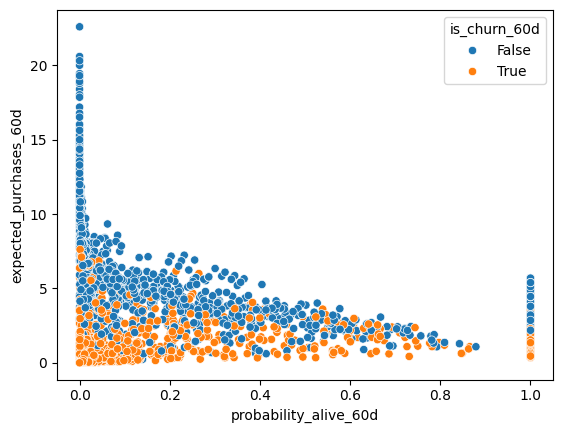

In [8]:
sns.scatterplot(data=summary, x="probability_alive_60d", y="expected_purchases_60d", hue="is_churn_60d")

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

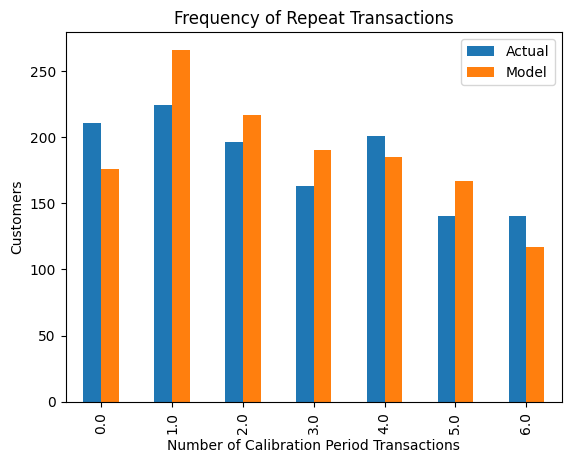

In [9]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

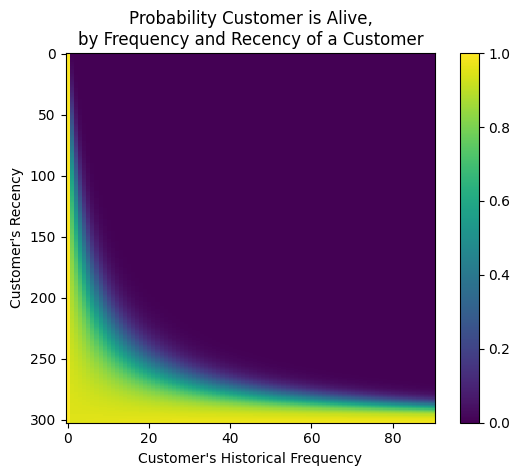

In [10]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

## Save summary data

In [11]:
summary.to_csv("../data/transaction_summary.csv")